# MNIST Neural Network



## Loading Data

Load MNIST dataset, and split the training images into 80% images to use for training and 20% images to use for validation.  
(N.B. The images are greyscale values ranging from 0.0 to 255.0, so will later need rescaling from 0.0 to 1.0)

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd

In [2]:
def preprocess(image, label):
    # Cast to float32, normalise, and reshape to (28, 28, 1)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, (28, 28, 1))
    return image, label

batch_size = 10

# Load datasets
train_digits = tfds.load('mnist', split='train[:80%]', shuffle_files=True, as_supervised=True)
val_digits   = tfds.load('mnist', split='train[80%:]', as_supervised=True)
test_digits  = tfds.load('mnist', split='test', as_supervised=True)

# Apply preprocessing and batching
train_digits = train_digits.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_digits   = val_digits.map(preprocess).batch(batch_size)
test_digits  = test_digits.map(preprocess).batch(batch_size)

## Create CNN

Create Convolutional Neural Network model to train on MNIST data.

In [5]:
input_shape = (28, 28, 1)
input = tf.keras.Input(shape=(28, 28, 1))
regularizer = tf.keras.regularizers.L2(0.005)

# Conv2d layer, with 32 5x5 filter and stride 1
Z1 = tf.keras.layers.Conv2D(32, (5, 5), strides=1, activity_regularizer=regularizer)(input)
# ReLU
A1 = tf.keras.layers.ReLU()(Z1)
# SeparableConv2d layer, with 32 5x5 filters and stride 1
Z2 = tf.keras.layers.SeparableConv2D(32, (5, 5), strides=1, activity_regularizer=regularizer)(A1)
# ReLU
A2 = tf.keras.layers.ReLU()(Z2)
# Max Pooling window 2x2, stride 2
P1 = tf.keras.layers.MaxPool2D((2,2), (2,2))(A2)
# Cov2d layer, with 40 5x5 filters and stride 2
Z3 = tf.keras.layers.Conv2D(64, (5, 5), padding='same', strides=1, activity_regularizer=regularizer)(P1)
# ReLU
A3 = tf.keras.layers.ReLU()(Z3)
# Conv2d 'network' layer, to halve num of channels
Z4 = tf.keras.layers.Conv2D(32, (1, 1), strides=1, activity_regularizer=regularizer)(A3)
# ReLU
A4 = tf.keras.layers.ReLU()(Z4)
# SeparableConv2d layer, with 32 3x3 filters and stride 1
Z5 = tf.keras.layers.SeparableConv2D(32, (3,3), strides=1, activity_regularizer=regularizer)(A4)
# ReLU
A5 = tf.keras.layers.ReLU()(Z5)
# Max pooling window 2x2, stride 2
P2 = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(A4)
# Flatten
F = tf.keras.layers.Flatten()(P2)
FD = tf.keras.layers.Dropout(0.4)(F)
# dense layer, 80 nodes
D1 = tf.keras.layers.Dense(80, activation='relu', activity_regularizer=regularizer)(FD)
D1D = tf.keras.layers.Dropout(0.4)(D1)
# output layer
output = tf.keras.layers.Dense(10, activation='softmax')(D1D)

model = tf.keras.Model(inputs=input, outputs=output)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 20, 20, 32)     │         1,856 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 10, 10, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 80)             │        64,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,922 (472.35 KB)

 Trainable params: 120,922 (472.35 KB)

 Non-trainable params: 0 (0.00 B)

## Train Model

Train the model on the training data, and use validation data to track accuracy and progress

In [7]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.8

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_digits, epochs=20, validation_data=val_digits, callbacks=[callback])

Epoch 1/20
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 114s 24ms/step - accuracy: 0.9603 - loss: 0.3224 - val_accuracy: 0.9795 - val_loss: 0.2110 - learning_rate: 0.0010
Epoch 2/20
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 135s 28ms/step - accuracy: 0.9617 - loss: 0.3040 - val_accuracy: 0.9802 - val_loss: 0.2429 - learning_rate: 0.0010
Epoch 3/20
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 190s 40ms/step - accuracy: 0.9634 - loss: 0.2911 - val_accuracy: 0.9808 - val_loss: 0.2426 - learning_rate: 0.0010
Epoch 4/20
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 174s 36ms/step - accuracy: 0.9633 - loss: 0.2865 - val_accuracy: 0.9796 - val_loss: 0.1785 - learning_rate: 0.0010
Epoch 5/20
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 171s 36ms/step - accuracy: 0.9635 - loss: 0.2816 - val_accuracy: 0.9836 - val_loss: 0.2095 - learning_rate: 0.0010
Epoch 6/20
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 154s 32ms/step - accuracy: 0.9684 - loss: 0.2402 - val_accuracy: 0.9817 - val_loss: 0.2358 - learning_rate: 8.0000e-04
Epoch 7/20
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 143s 30ms/st

### View Training History

C:\Users\User\AppData\Local\Temp\ipykernel_10416\1989446866.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss': 'Training', 'val_loss': 'Validation'}, inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_10416\1989446866.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy': 'Training', 'val_accuracy': 'Validation'}, inplace=True)


<Axes: title={'center': 'Model Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>

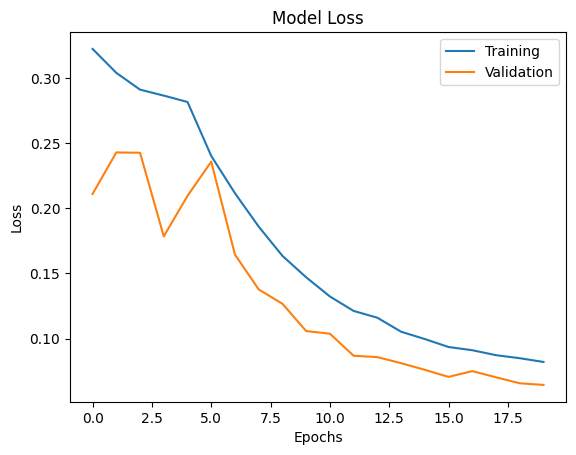

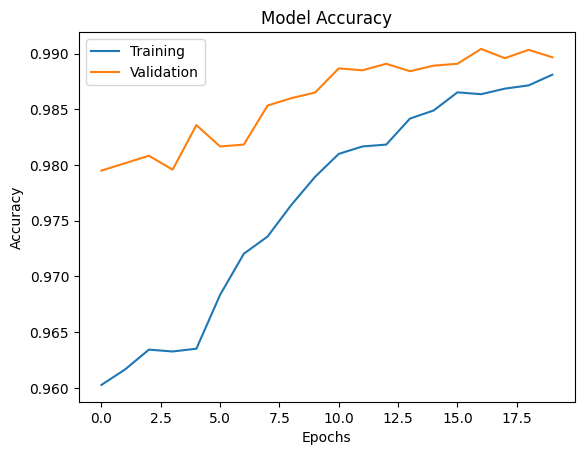

In [8]:
df_loss_acc = pd.DataFrame(history.history)
df_loss = df_loss_acc[['loss', 'val_loss']]
df_loss.rename(columns={'loss': 'Training', 'val_loss': 'Validation'}, inplace=True)

df_acc = df_loss_acc[['accuracy', 'val_accuracy']]
df_acc.rename(columns={'accuracy': 'Training', 'val_accuracy': 'Validation'}, inplace=True)

df_loss.plot(title='Model Loss', ylabel='Loss', xlabel='Epochs')
df_acc.plot(title='Model Accuracy', ylabel='Accuracy', xlabel='Epochs')

# Test Model

Test the model on test data.

In [9]:
model.evaluate(test_digits)

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9912 - loss: 0.0578


[0.05775720253586769, 0.9911999702453613]

### (Optional) Save Model

Save model weights, biases and structure so it can later be loaded and recreated.

In [10]:

model.save('mnist_separable_conv_reg_dropout_98.12.keras')